In [119]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib import rcParams
from torch import nn
from tqdm.notebook import tqdm

from experiments.utils import train_loop
from models import LSTMLabelEndClassifier

# Training models

In [8]:
import json

from nltk.stem import PorterStemmer, SnowballStemmer

from document_dataset import LabeledDocumentDataset, DocumentDataset


with open('data/word_idx_snowball.json') as f:
    word_idx = json.load(f)


stemmer = SnowballStemmer('russian')
with open('data/first_label_train.json') as first_train, open('data/first_label_test.json') as first_test:
    first_train_dataset = LabeledDocumentDataset(json.load(first_train), word_idx, stemmer=stemmer.stem, max_document_length=800, add_end_token=True)
    first_test_dataset = LabeledDocumentDataset(json.load(first_test), word_idx, stemmer=stemmer.stem, max_document_length=800, add_end_token=True)

with open('data/second_label_train.json') as second_train, open('data/second_label_test.json') as second_test:
    second_train_dataset = LabeledDocumentDataset(json.load(second_train), word_idx, stemmer=stemmer.stem, max_document_length=800)
    second_test_dataset = LabeledDocumentDataset(json.load(second_test), word_idx, stemmer=stemmer.stem, max_document_length=800)

In [9]:
from torch.utils.data import DataLoader


first_train_dataloader = DataLoader(first_train_dataset, batch_size=32, shuffle=True)
first_test_dataloader = DataLoader(first_test_dataset, batch_size=500)
second_train_dataloader = DataLoader(second_train_dataset, batch_size=32, shuffle=True)
second_test_dataloader = DataLoader(second_test_dataset, batch_size=500)

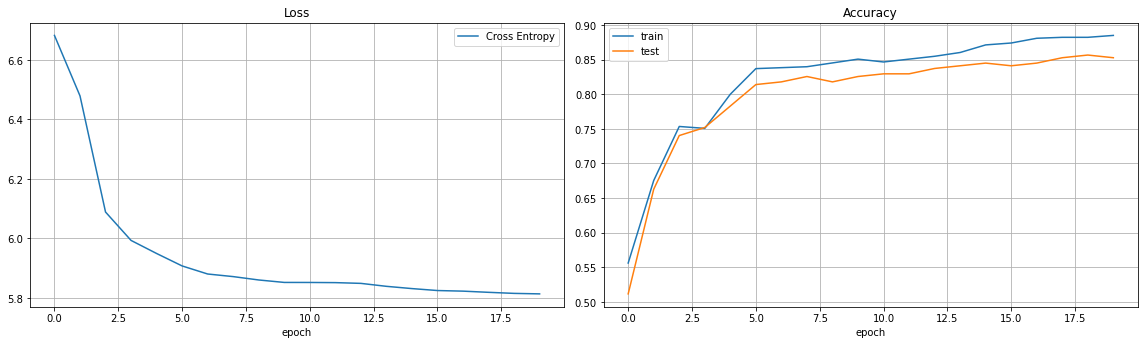

In [10]:
first_label_start_clf = LSTMLabelEndClassifier(
    len(word_idx),
    hidden_size=32,
    embedding_dim=32,
    dropout=0.2,
    bidirectional=True,
)

train_loop(
    n_epoch=20,
    train_dataloader=first_train_dataloader,
    test_dataloader=first_test_dataloader,
    lr=0.002,
    clf=first_label_start_clf,
    train_on_start=True
)

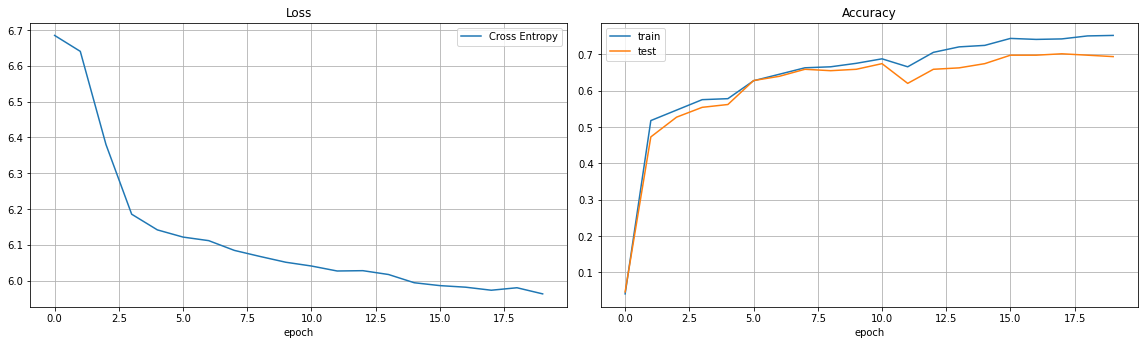

In [15]:
first_label_end_clf = LSTMLabelEndClassifier(
    len(word_idx),
    hidden_size=32,
    embedding_dim=32,
    dropout=0.3,
    bidirectional=True,
)

train_loop(
    n_epoch=20,
    train_dataloader=first_train_dataloader,
    test_dataloader=first_test_dataloader,
    lr=0.002,
    clf=first_label_end_clf,
    train_on_start=False
)

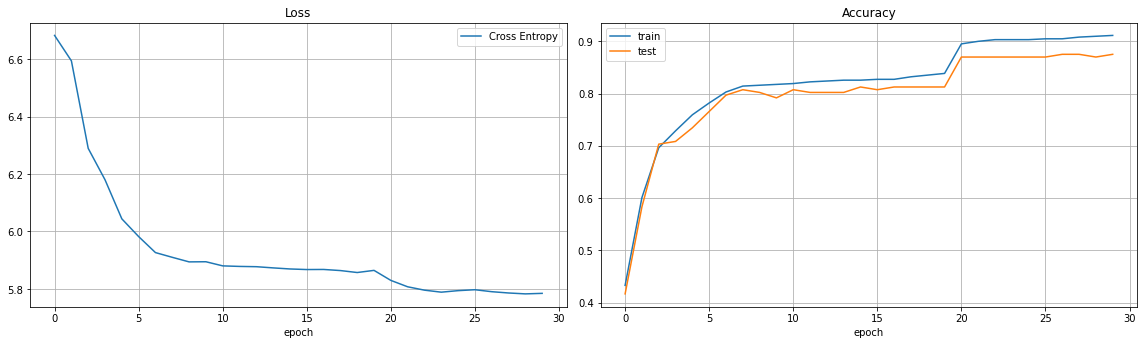

In [17]:
second_label_start_clf = LSTMLabelEndClassifier(
    len(word_idx),
    hidden_size=32,
    embedding_dim=32,
    dropout=0.2,
    bidirectional=True,
)

train_loop(
    n_epoch=30,
    train_dataloader=second_train_dataloader,
    test_dataloader=second_test_dataloader,
    lr=0.002,
    clf=second_label_start_clf,
    train_on_start=True
)

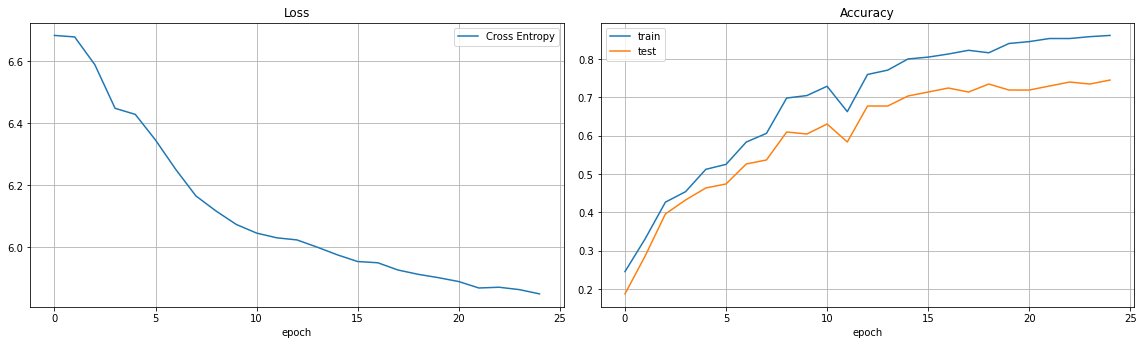

In [22]:
second_label_end_clf = LSTMLabelEndClassifier(
    len(word_idx),
    hidden_size=16,
    embedding_dim=32,
    dropout=0.1,
    bidirectional=True,
)

train_loop(
    n_epoch=25,
    train_dataloader=second_train_dataloader,
    test_dataloader=second_test_dataloader,
    lr=0.002,
    clf=second_label_end_clf,
    train_on_start=False
)

# Calculating test accuracy

In [114]:
with open('data/test_split.json') as f_test:
    test_dataset = LabeledDocumentDataset(json.load(f_test), word_idx, stemmer=stemmer.stem, max_document_length=800, add_end_token=True)

In [179]:
def make_prediction(clf, sequence):
    clf.eval()
    with torch.no_grad():
        y_pred = clf(sequence.reshape(1, -1)).detach().numpy()
    predicted_labels = np.eye(y_pred.shape[1])[np.argmax(y_pred, axis=1)]

    return predicted_labels

In [180]:
import re


def _fix_num(match):
    if not match:
        return ''
    if '.' in match.group(0):
        return match.group(1) + '.' + match.group(2)
    elif ',' in match.group(0):
        return match.group(1) + ',' + match.group(2)

    return ''
    


def fix_text(text):
    num_delim_regex = r'(\d)\s[\.,]\s(\d)'
    text = re.sub(num_delim_regex, _fix_num, text)
    text = text.replace(' : ', ': ')
    text = text.replace(' %', '%')
    text = text.replace('( ', '(')
    text = text.replace(' )', ')')
    text = text.replace(' . ', '. ')
    text = text.replace(' .', '.')
    text = text.replace(' ,', ', ')

    return text

In [181]:
def extract_text(text, start_token_idx, end_token_idx):
    tokenized = submission_dataset._tokenize(text)
    encoded = submission_dataset._encode_text(text)

    if encoded[start_token_idx] in (word_idx['<pad>'], word_idx['<end>']):
        return "", 0, 0
    elif encoded[end_token_idx] in (word_idx['<pad>'], word_idx['<end>']):
        return "", 0, 0

    detokenized = fix_text(' '.join(tokenized))
    extracted = fix_text(' '.join(tokenized[start_token_idx:end_token_idx]))
    start_text_idx = detokenized.find(extracted)
    end_text_idx = start_text_idx + len(extracted)

    return extracted, start_text_idx, end_text_idx

In [182]:
def extract_label(document, sequence, label):
    if label == 0:
        start_pred = make_prediction(first_label_start_clf, sequence)
        end_pred = make_prediction(first_label_end_clf, sequence)
    else:
        start_pred = make_prediction(second_label_start_clf, sequence)
        end_pred = make_prediction(second_label_end_clf, sequence)
    start_token_idx = np.argmax(start_pred)
    end_token_idx = np.argmax(end_pred)

    return extract_text(document, start_token_idx, end_token_idx)

In [183]:
def calculate_accuracy(dataset):
    # compares only texts
    correct = 0
    for i, (sequence, label, _, _) in enumerate(tqdm(dataset)):
        document = dataset._documents[i]['text']
        extracted, _, _ = extract_label(document, sequence, label)
        if extracted == dataset._documents[i]['extracted_part']['text'][0]:
            correct += 1

    return correct / len(dataset)

In [184]:
calculate_accuracy(test_dataset)

  0%|          | 0/450 [00:00<?, ?it/s]

0.5066666666666667

# Making submission

In [26]:
with open('../dataset/test.json') as f_sub:
    submission_dataset = DocumentDataset(json.load(f_sub), word_idx, stemmer=stemmer.stem, max_document_length=800, add_end_token=True)

In [185]:
def generate_submission(dataset):
    result = []
    for i, (sequence, label) in enumerate(tqdm(dataset)):
        document_copy = dataset._documents[i].copy()
        extracted, start, end = extract_label(document_copy['text'], sequence, label)
        document_copy['extracted_part'] = {
            'text': extracted,
            'answer_start': start,
            'answer_end': end,
        }
        result.append(document_copy)

    return result

In [189]:
submission = generate_submission(submission_dataset)

  0%|          | 0/318 [00:00<?, ?it/s]

In [190]:
submission[0]

{'id': 762883279,
 'text': 'МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание услуг по техническому обслуживанию и ремонту принтеров и многофункциональных устройств, заправке и восстановлению картриджей (идентификационный код закупки 223861800296886010100100590019511244) г. Ханты-Мансийск «___» ____________ 2022 г.  (или) возмещения убытков причинённых Исполнителем убытков. 6. Обеспечение исполнения контракта 6.1. Исполнение контракта обеспечиваются предоставлением независимой гарантии, выданной банком и соответствующей требованиям Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд», или внесением денежных средств на указанный заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими заказчику. Способ обеспечения исполнения контракта, срок действия независимой гарантии определяются в соответствии с требованиями Фед

In [191]:
with open('../predictions.json', 'w') as f:
    json.dump(submission, f)